In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import Tuple
from mip.display.image import show, read, subplot_images

In [ ]:
def grad(I: np.ndarray) -> np.ndarray:
    """
    Computes the gradient of an image I.
    --------
    Parameters:
    I: np.ndarray
    --------
    Returns:
    grad_x: np.ndarray    
    """
    M, N = I.shape
    G = np.zeros((M, N, 2))
    G[:, 1:, 0] = I[:, 1:] - I[:, :-1]
    G[:, 0, 0] = I[:, 0]
    G[1:, :, 1] = I[1:, :] - I[:-1, :]
    G[0, :, 1] = I[0, :]
    return G

In [5]:
def divergence(G: np.ndarray) -> np.ndarray:
    """
    Computes the divergence of the gradient.
    --------
    Parameters:
    grad_x: np.ndarray
    grad_y: np.ndarray
    --------
    Returns:
    div: np.ndarray    
    """
    M, N, _ = G.shape
    p = np.zeros((M, N))
    p[:, :-1] += G[:, :-1, 0]
    p[:, 1:] -= G[:, :-1, 0]
    p[:, 0] = -G[:, 0, 0]
    p[:-1, :] += G[:-1, :, 1]
    p[1:, :] -= G[:-1, :, 1]
    p[0, :] = -G[0, :, 1]
    return p

In [6]:
def compute_energy(u, f, lambd):
    """ Compute the energy functional J(u). """
    G = grad(u)
    tv_norm = np.sqrt(G[:, :, 0]**2 + G[:, :, 1]**2).sum()
    data_fidelity = 0.5 * np.linalg.norm(u - f)**2
    return data_fidelity + lambd * tv_norm

In [7]:
def ROF_gradient(I, lambd, tau=0.1, epsilon=1e-3, num_iter=100):
    """ Perform the regularized gradient descent for ROF denoising. """
    u = I.copy()
    energy = []

    for t in range(num_iter):
        G = grad(u)
        norm_grad_u = np.sqrt(G[:, :, 0]**2 + G[:, :, 1]**2 + epsilon**2)
        G[:, :, 0] /= norm_grad_u
        G[:, :, 1] /= norm_grad_u
        div_term = divergence(G)
        
        # Update rule
        u = u - tau * (u - I - lambd * div_term)
        
        # Compute and store energy
        energy.append(compute_energy(u, I, lambd))
    
    return u, energy


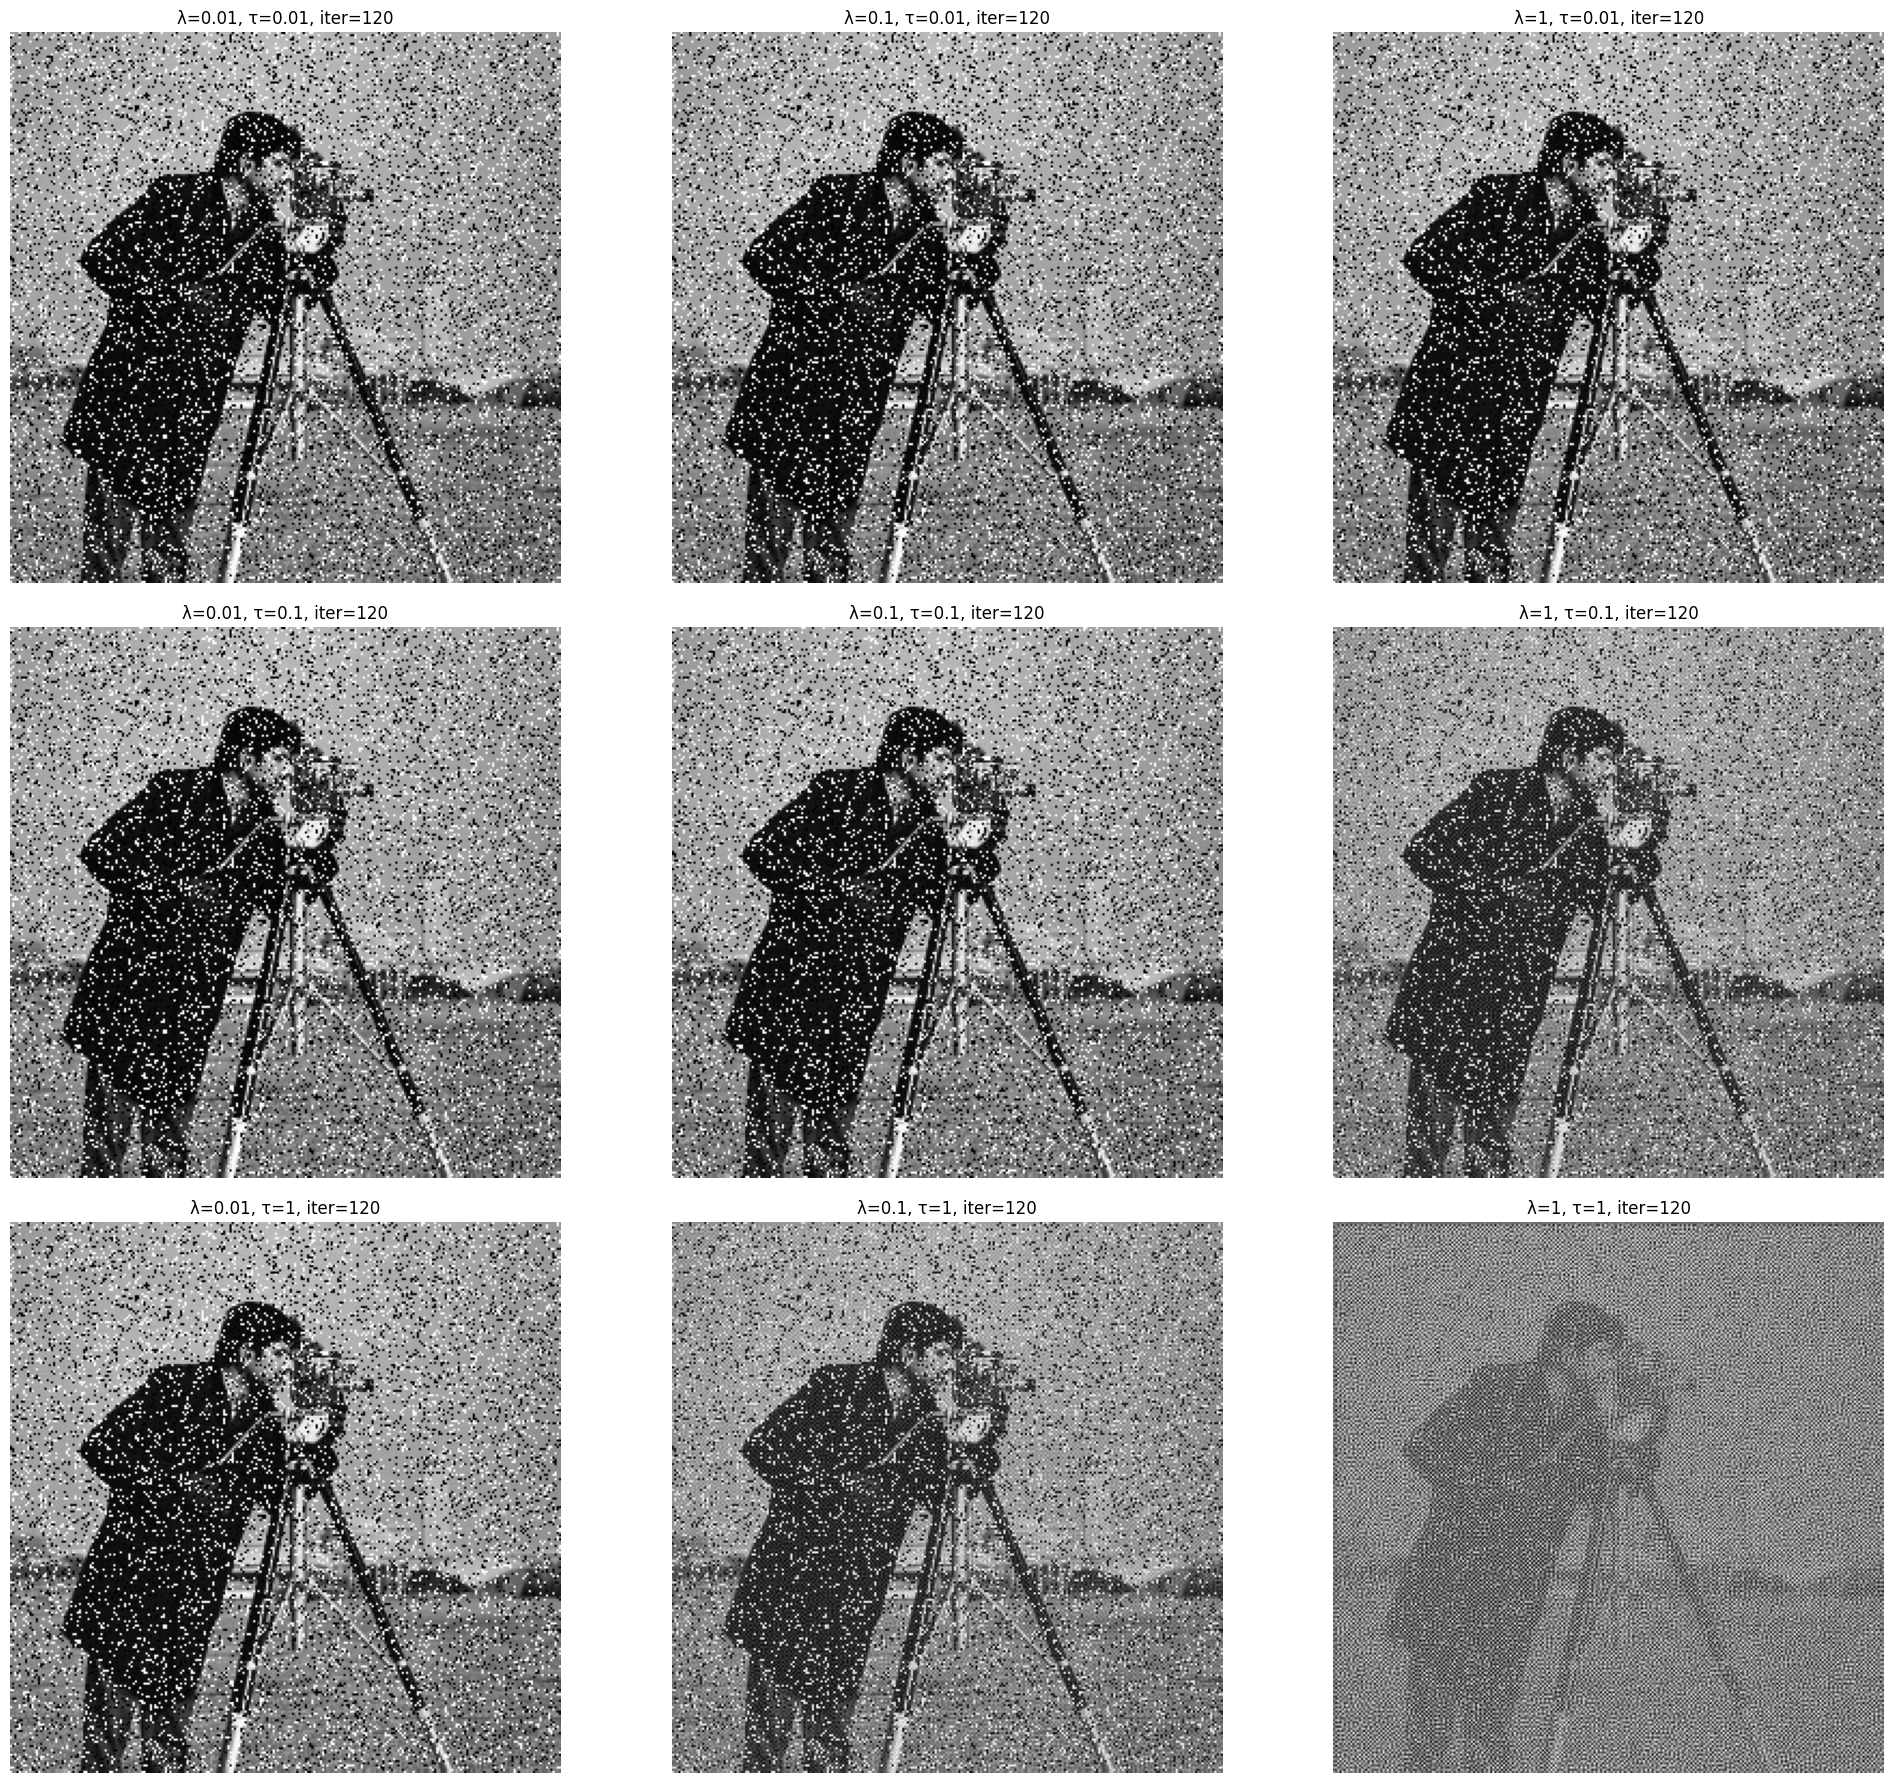

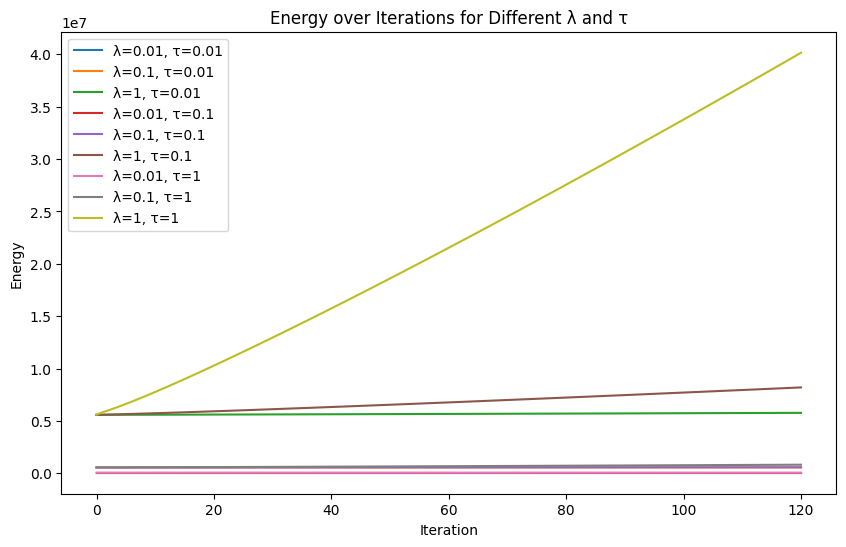

In [8]:
img = read("../assets/cameraman_sp.png", 'GRAY')
images = []
taus = [0.01, 0.1, 1]
lambdas = [0.01, 0.1, 1]
epsilon = 1e-8

titles = []
iterations = 120
every = 120

energy_plot_data = []

for tau in taus:
    for lambda_ in lambdas:
        timg = img.copy()
        energies = []
        for i in range(iterations + 1):
            timg, energy = ROF_gradient(timg, lambda_, tau, epsilon, 1)
            energies.extend(energy)
            if i > 0 and i % every == 0:
                images.append(timg)
                titles.append(f'λ={lambda_}, τ={tau}, iter={i}')
        energy_plot_data.append((lambda_, tau, energies))

# Plot images
subplot_images(images, titles=titles, fig_size=(20, 18), order=(-1, 3), dpi=100).savefig('totalVariation.png')

# Plot energy
plt.figure(figsize=(10, 6))
for lambda_, tau, energies in energy_plot_data:
    plt.plot(energies, label=f'λ={lambda_}, τ={tau}')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy over Iterations for Different λ and τ')
plt.savefig('energy_plot.png')
plt.show()

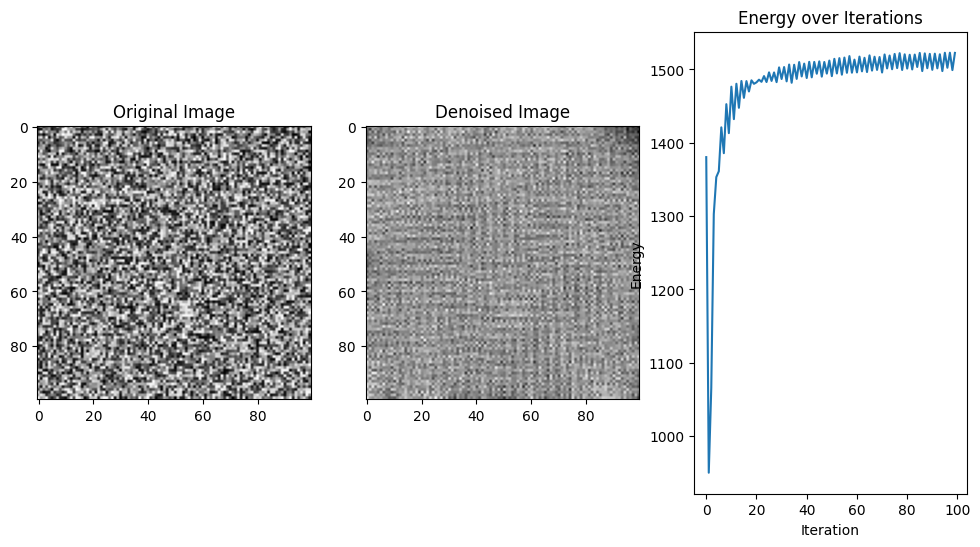

In [3]:
import numpy as np
from scipy.ndimage import sobel
import matplotlib.pyplot as plt

def gradient(u):
    """ Compute the gradient of u. """
    ux = sobel(u, axis=0, mode='reflect')
    uy = sobel(u, axis=1, mode='reflect')
    return ux, uy

def divergence(ux, uy):
    """ Compute the divergence of (ux, uy). """
    uxx = sobel(ux, axis=0, mode='reflect')
    uyy = sobel(uy, axis=1, mode='reflect')
    return uxx + uyy

def compute_energy(u, f, lambd):
    """ Compute the energy functional J(u). """
    ux, uy = gradient(u)
    tv_norm = np.sqrt(ux**2 + uy**2).sum()
    data_fidelity = 0.5 * np.linalg.norm(u - f)**2
    return data_fidelity + lambd * tv_norm

def ROF_gradient(I, lambd, tau=0.1, epsilon=1e-3, num_iter=100):
    """ Perform the regularized gradient descent for ROF denoising. """
    u = I.copy()
    energy = []

    for t in range(num_iter):
        ux, uy = gradient(u)
        norm_grad_u = np.sqrt(ux**2 + uy**2 + epsilon**2)
        div_term = divergence(ux / norm_grad_u, uy / norm_grad_u)
        
        # Update rule
        u = u - tau * (u - I - lambd * div_term)
        
        # Compute and store energy
        energy.append(compute_energy(u, I, lambd))
    
    return u, energy

# Example usage
if __name__ == "__main__":
    # Load an example image (replace with actual image loading code)
    I = np.random.rand(100, 100)  # Example with random image, replace with actual image
    lambd = 0.2
    tau = 0.1
    epsilon = 1e-3
    num_iter = 100
    
    u, energy = ROF_gradient(I, lambd, tau, epsilon, num_iter)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(I, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(u, cmap='gray')
    plt.title('Denoised Image')
    plt.subplot(1, 3, 3)
    plt.plot(energy)
    plt.title('Energy over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.show()
